# Ambiente

In [ ]:
# !pip install -r requirements.txt

# import capymoa
# print(capymoa.__version__)

In [66]:
# Bibliotecas Padrão
import os
import time
import warnings
from datetime import datetime

# Dados e ML
import joblib
import numpy as np
import pandas as pd
from capymoa.classifier import LeveragingBagging
from capymoa.classifier import HoeffdingAdaptiveTree
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.evaluation import ClassificationEvaluator, prequential_evaluation
from capymoa.stream import NumpyStream
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Base de Dados

## CICDDoS2019

### Downsample [Personalizado] 

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'
DOWNSAMPLE_FACTORS = {
    'TFTP': 0.001,  # Redução mais agressiva 
    'MSSQL': 0.001,
    'Default': 0.01  
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11_Test.csv',
    '01-12': 'CICDDoS2019_01_12_Train.csv'
}

In [ ]:
def processar_e_salvar_dia(dia, dataset_path, chunk_size, cols_to_drop, attack_order, output_files):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Limpeza de Colunas
                cols_existentes_drop = [col for col in cols_to_drop if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                df_chunk[ATTACK_LABEL_COL] = df_chunk[ATTACK_LABEL_COL].apply(
                    lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                )
                
                df_benign = df_chunk[df_chunk[ATTACK_LABEL_COL] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[ATTACK_LABEL_COL] != BENIGN_LABEL]

                # Downsampling Seletivo nos Ataques
                df_ataque_downsampled = df_ataque

                if not df_ataque.empty:
                    # Fator de Downsample específico
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    # Se o número de amostras for MENOR que o mínimo, não fazemos Downsample (mantemos 100%)
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque_downsampled = df_ataque.sample(
                            frac=factor, 
                            random_state=42
                        )

                # Combina (BENIGN 100% + Ataque Reduzido) e Embaralha
                df_chunk_reduzido = pd.concat([df_benign, df_ataque_downsampled]).sample(frac=1, random_state=42)
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento do Chunk Imediato
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
# tamanho_teste = processar_e_salvar_dia(
#     dia='03-11', 
#     dataset_path=DATASET_PATH,
#     chunk_size=PANDAS_CHUNK_SIZE,
#     cols_to_drop=COLUMNS_TO_DROP,
#     attack_order=ATTACK_ORDER,
#     output_files=OUTPUT_FILES
# )
# print(f"Dataset de Teste salvo: {OUTPUT_FILES['03-11']} (Total: {tamanho_teste:,} amostras)")

# tamanho_treino = processar_e_salvar_dia(
#     dia='01-12', 
#     dataset_path=DATASET_PATH,
#     chunk_size=PANDAS_CHUNK_SIZE,
#     cols_to_drop=COLUMNS_TO_DROP,
#     attack_order=ATTACK_ORDER,
#     output_files=OUTPUT_FILES
# )
# print(f"Dataset de Treino salvo: {OUTPUT_FILES['01-12']} (Total: {tamanho_treino:,} amostras)")

Dataset de Teste salvo: CICDDoS2019_03_11_Test.csv (Total: 208,102 amostras)
Dataset de Treino salvo: CICDDoS2019_01_12_Train.csv (Total: 376,216 amostras)


## CIC-IDS-2017

## Funções de Pré-processamento

In [68]:
def preprocess_stream_dataframe(df, target_label_col, timestamp_col, le_fit=None, is_train=False):
    print("Iniciando pré-processamento inicial...")
    df_processed = df.copy()
    
    # --- Renomeia as colunas ---
    original_cols = df_processed.columns
    df_processed.columns = df_processed.columns.str.strip()
    target_label_col = target_label_col.strip()
    timestamp_col = timestamp_col.strip()
    print(f"  [Passo 1/4] Colunas renomeadas.")

    # --- Trata Timestamp e Ordena ---
    if timestamp_col in df_processed.columns:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df_processed[timestamp_col] = pd.to_datetime(df_processed[timestamp_col], errors='coerce')
        if not df_processed[timestamp_col].isnull().all():
            print(f"  [Passo 2/4] (Re)Ordenando DataFrame por '{timestamp_col}'...")
            df_processed.sort_values(by=timestamp_col, inplace=True)
            df_processed.reset_index(drop=True, inplace=True)
    
    # --- Trata valores infinitos ---
    print("  [Passo 3/4] Convertendo valores Infinitos para NaN...")
    df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # --- Codifica Rótulos ---
    print(f"  [Passo 4/4] Codificando rótulos da coluna '{target_label_col}'...")
    le = le_fit
    if target_label_col in df_processed.columns:
        if is_train:
            print("    - AJUSTANDO (FIT) LabelEncoder nos dados do 'Passado'.")
            le = LabelEncoder()
            df_processed[target_label_col] = le.fit_transform(df_processed[target_label_col].astype(str))
        elif le_fit is not None:
            print("    - APLICANDO (TRANSFORM) LabelEncoder nos dados do 'Futuro'.")
            known_classes = set(le.classes_)
            df_processed[target_label_col] = df_processed[target_label_col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in known_classes else -1
            )
            if (df_processed[target_label_col] == -1).any():
                print("    - [SUCESSO] Rótulos novos (não vistos no Passado) encontrados e codificados como -1.")
        else:
            print(f"    - ERRO: 'is_train=False' mas 'le_fit' não foi fornecido.")
    else:
        print(f"    - Aviso: Coluna de rótulo '{target_label_col}' não encontrada.")
        
    print(f"\nPré-processamento inicial concluído. Shape: {df_processed.shape}")
    return df_processed, le

def analisar_qualidade_dados(df, nome_df="DataFrame"):
    print(f"\n--- Verificando Qualidade (antes da limpeza final): {nome_df} ---")

    nan_counts = df.isnull().sum()
    nan_counts_filtered = nan_counts[nan_counts > 0].sort_values(ascending=False)
    if nan_counts_filtered.empty:
        print("  [OK] Nenhum valor nulo (NaN) encontrado.")
    else:
        print(f"  [INFO] {nan_counts_filtered.sum()} valores nulos a serem tratados por 'criar_stream'.")
        print(f"     (Top 5 colunas com nulos: {nan_counts_filtered.head(5).index.tolist()})")

    # Verifica Infinitos 
    df_numeric = df.select_dtypes(include=np.number)
    if not df_numeric.empty:
        inf_counts = np.isinf(df_numeric).sum().sum()
        if inf_counts > 0:
            print(f"  [ALERTA] {inf_counts} valores infinitos ainda presentes! (Verificar Passo 3 da função anterior)")
        else:
            print("  [OK] Nenhum valor infinito encontrado.")

def criar_stream(df, target_label_col, timestamp_col, cols_para_remover, stream_name_prefix, output_csv_path):
    print(f"\n--- Iniciando Limpeza Final e Salvamento: {stream_name_prefix} ---")
    
    target_label_col = target_label_col.strip()
    timestamp_col = timestamp_col.strip()
    cols_para_remover_normalizadas = [col.strip() for col in cols_para_remover]

    if target_label_col not in df.columns:
        print(f"    - ERRO: Coluna de rótulo '{target_label_col}' não encontrada.")
        return

    y_data_series = df[target_label_col].copy()
    
    todas_cols_para_remover = [target_label_col, timestamp_col] + cols_para_remover_normalizadas
    cols_existentes_para_remover = [col for col in todas_cols_para_remover if col in df.columns]
    
    print(f"  [Passo 1/4] Removendo {len(cols_existentes_para_remover)} colunas desnecessárias.")
    X_data_df = df.drop(columns=cols_existentes_para_remover, errors='ignore')

    X_data_df_numeric = X_data_df.select_dtypes(include=np.number)
    non_numeric_cols = X_data_df.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"    - Aviso: Removendo {len(non_numeric_cols)} colunas não numéricas que sobraram.")
    
    print(f"  [Passo 2/4] DataFrame de features (X) reduzido a {X_data_df_numeric.shape[1]} colunas.")

    print("  [Passo 3/4] Imputando valores nulos (NaN) restantes com a MEDIANA...")
    nan_counts = X_data_df_numeric.isnull().sum().sum()
    if nan_counts > 0:
        X_data_df_cleaned = X_data_df_numeric.fillna(X_data_df_numeric.median()).fillna(0)
    else:
        X_data_df_cleaned = X_data_df_numeric
        
    df_stream_pronto = pd.concat([X_data_df_cleaned, y_data_series], axis=1)
    
    try:
        print(f"  [Passo 4/4] Salvando stream PRONTO em '{output_csv_path}'...")
        df_stream_pronto.to_csv(output_csv_path, index=False)
        print("    - Salvamento em CSV concluído.")
    except Exception as e:
        print(f"    - ERRO: Falha ao salvar CSV. Erro: {e}")
    

def carregar_stream_do_csv(csv_path, target_col_name, stream_name_prefix="loaded_stream"):
    print(f"\n--- Carregando Stream do CSV: {csv_path} ---")
    
    try:
        df_reload = pd.read_csv(csv_path)
        print(f"  [Passo 1/2] CSV carregado. Shape: {df_reload.shape}")
    except FileNotFoundError:
        print(f"    - ERRO: Arquivo CSV não encontrado em '{csv_path}'")
        return None
    except Exception as e:
        print(f"    - ERRO: Falha ao ler o CSV: {e}")
        return None

    if df_reload.empty:
        print("    - ERRO: O CSV está vazio.")
        return None

    # --- Separar X e y ---
    if df_reload.columns[-1] != target_col_name.strip():
        print(f"    - Aviso: A última coluna é '{df_reload.columns[-1]}', mas esperava-se '{target_col_name.strip()}'.")
        # Mesmo assim, continuamos assumindo que é o rótulo.
        
    # Pega todas as colunas, exceto a última
    X_data_df = df_reload.iloc[:, :-1]
    # Pega apenas a última coluna
    y_data_series = df_reload.iloc[:, -1]
    
    # Converte X para o formato float64 necessário
    X_data = X_data_df.values.astype(np.float64)
    y_data = y_data_series.values # Rótulo já deve estar codificado

    print(f"  [Passo 2/2] Dados preparados: X_shape={X_data.shape}, y_shape={y_data.shape}.")

    # --- Cria o NumpyStream ---
    if NumpyStream:
        try:
            stream = NumpyStream(
                X_data,
                y_data,
                target_name=target_col_name.strip(), # Nomeia o alvo
                dataset_name=stream_name_prefix
            )
            stream.restart() 
            print("Stream (Capymoa) recarregado e pronto para uso.")
            return stream
        except Exception as e:
            print(f"    - ERRO AO CRIAR STREAM: {e}")
            return None
    else:
        print("    - ERRO: (Biblioteca 'capymoa' não encontrada).")
        return None
    

def gerar_relatorio_e_heatmap(y_true, y_pred, label_encoder, model_name=""):
    print(f"\n--- Análise Detalhada (Teste 'Futuro') para: {model_name} ---")
    
    # Obter todos os rótulos (índices)
    # Pega todos os índices que apareceram no teste OU nas predições
    all_labels_indices = sorted(list(set(y_true) | set(y_pred)))
    
    # Mapear índices para nomes (strings)
    try:
        # Mapeia os índices conhecidos (ex: 0, 1, 2...)
        known_indices = [i for i in all_labels_indices if i != -1]
        known_names = label_encoder.inverse_transform(known_indices)
        
        # Cria a lista de nomes final, tratando o -1
        all_labels_names = [str(i) for i in all_labels_indices]
        if -1 in all_labels_indices:
            all_labels_names[all_labels_indices.index(-1)] = "NOVO_ROTULO (-1)"
        
        # Substitui os nomes conhecidos na lista final
        for idx, name in zip(known_indices, known_names):
            all_labels_names[all_labels_indices.index(idx)] = name
            
    except ValueError:
        print(f"Aviso: Índices {all_labels_indices} não puderam ser mapeados. Usando índices.")
        all_labels_names = [str(i) for i in all_labels_indices]
    except Exception as e:
        print(f"Erro ao mapear rótulos: {e}")
        all_labels_names = [str(i) for i in all_labels_indices]

    # Relatório de Classificação (sklearn)
    print("\nRelatório de Classificação (Teste 'Futuro'):")
    report = classification_report(
        y_true, y_pred, 
        labels=all_labels_indices, 
        target_names=all_labels_names,
        zero_division=0, digits=4
    )
    print(report)

    # Heatmap da Matriz de Confusão (sklearn + seaborn)
    print("\nGerando Heatmap da Matriz de Confusão...")
    cm = confusion_matrix(y_true, y_pred, labels=all_labels_indices)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", 
        xticklabels=all_labels_names, 
        yticklabels=all_labels_names
    )
    plt.title(f'Matriz de Confusão - {model_name} - Teste')
    plt.xlabel('Rótulo Predito')
    plt.ylabel('Rótulo Real')
    plt.tight_layout()
    plt.show() # Exibe o gráfico

## Processando e Criando Stream para treinamento dos modelos

In [ ]:
ENCODER_PATH = "datasets/label_encoder_treino.joblib" 
TARGET_COL = ' Label'
TIME_COL = ' Timestamp'
SPLIT_RATIO = 0.8  # 80% Passado (Treino) / 20% Futuro (Teste)

# CICDDoS2019 dia 01-12 
FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
PATH_CSV_TREINO = r'datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv'
PATH_CSV_TESTE = r'datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv'

# CICDDoS2019 dia 03-11
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# PATH_CSV_TREINO = r'datasets\CICDDoS2019\data\cicddos_stream_TREINO_0311.csv'
# PATH_CSV_TESTE = r'datasets\CICDDoS2019\data\cicddos_stream_TESTE_0311.csv'

# Colunas a serem removidas (não-features)
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

try:
    print(f"Carregando dados brutos de {FILE_RAW}...")
    df_raw = pd.read_csv(FILE_RAW)
    print(f"Dados carregados. Shape original: {df_raw.shape}")

    # --- ORDENAÇÃO CRONOLÓGICA ---
    print(f"\nOrdenando dataset inteiro por '{TIME_COL}'...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df_raw[TIME_COL] = pd.to_datetime(df_raw[TIME_COL], errors='coerce')
    
    df_raw.sort_values(by=TIME_COL, inplace=True)
    df_raw.reset_index(drop=True, inplace=True)
    print("Ordenação cronológica concluída.")

    # --- DIVISÃO TEMPORAL ---
    split_index = int(len(df_raw) * SPLIT_RATIO)
    
    df_train = df_raw.iloc[:split_index] 
    df_test = df_raw.iloc[split_index:]  
    
    print(f"\n--- Divisão Temporal Concluída ---")
    print(f"Shape Treino (Passado): {df_train.shape}")
    print(f"Shape Teste (Futuro):  {df_test.shape}")
    
    # --- INSPEÇÃO DE DADOS ---
    print(f"\n--- Rótulos no TREINO (Passado) ---")
    print(df_train[TARGET_COL].value_counts())
    
    print(f"\n--- Rótulos no TESTE (Futuro) ---")
    print(df_test[TARGET_COL].value_counts())
    
    # --- PROCESSAR E SALVAR TREINO (PASSADO) ---
    print("\n--- Processando DADOS DE TREINO ---")
    df_train_preprocessed, le_treino = preprocess_stream_dataframe(
        df=df_train, 
        target_label_col=TARGET_COL, 
        timestamp_col=TIME_COL, 
        le_fit=None,        # Nenhum (vamos treinar um novo)
        is_train=True       # SIM, é o treino
    )
    
    # Salva o encoder treinado APENAS no Passado
    joblib.dump(le_treino, ENCODER_PATH)
    print(f"\nLabelEncoder do 'Passado' (com {len(le_treino.classes_)} classes) salvo em: {ENCODER_PATH}")

    if df_train_preprocessed is not None:
        criar_stream(
            df=df_train_preprocessed, 
            target_label_col=TARGET_COL,
            timestamp_col=TIME_COL,
            cols_para_remover=COLS_NAO_FEATURES, 
            stream_name_prefix="PASSADO_TREINO",
            output_csv_path=PATH_CSV_TREINO
        )

    # --- PROCESSAR E SALVAR TESTE (FUTURO) ---
    print("\n--- Processando DADOS DE TESTE (Futuro) ---")
    df_test_preprocessed, _ = preprocess_stream_dataframe(
        df=df_test, 
        target_label_col=TARGET_COL, 
        timestamp_col=TIME_COL, 
        le_fit=le_treino, # USA O ENCODER DO PASSADO
        is_train=False    # NÃO, é o teste
    )
    
    if df_test_preprocessed is not None:
        criar_stream(
            df=df_test_preprocessed, 
            target_label_col=TARGET_COL,
            timestamp_col=TIME_COL,
            cols_para_remover=COLS_NAO_FEATURES, 
            stream_name_prefix="FUTURO_TESTE",
            output_csv_path=PATH_CSV_TESTE
        )
    
    print("\n[SUCCESS] Dados (Passado/Futuro) salvos.")
    
except NameError as e:
    print(f"ERRO: Funções não definidas. Certifique-se de que todas as definições de função estão na Célula 1. {e}")
except FileNotFoundError:
    print(f"ERRO: Arquivo RAW não encontrado em {FILE_RAW}")
except Exception as e:
    print(f"ERRO INESPERADO NA CÉLULA: {e}")

Carregando dados brutos de datasets\CICDDoS2019\CICDDoS2019_01_12.csv...
Dados carregados. Shape original: (376216, 85)

Ordenando dataset inteiro por ' Timestamp'...
Ordenação cronológica concluída.

--- Divisão Temporal Concluída ---
Shape Treino (Passado): (300972, 85)
Shape Teste (Futuro):  (75244, 85)

--- Rótulos no TREINO (Passado) ---
 Label
DrDoS_SNMP       51606
DrDoS_DNS        50715
DrDoS_MSSQL      45229
DrDoS_NetBIOS    40936
BENIGN           27402
DrDoS_SSDP       26109
DrDoS_UDP        25146
DrDoS_LDAP       21800
DrDoS_NTP        12029
Name: count, dtype: int64

--- Rótulos no TESTE (Futuro) ---
 Label
BENIGN       29461
TFTP         20087
Syn          15824
DrDoS_UDP     6203
UDPLag        3669
Name: count, dtype: int64

--- Processando DADOS DE TREINO ---
Iniciando pré-processamento inicial...
  [Passo 1/4] Colunas renomeadas.
  [Passo 2/4] (Re)Ordenando DataFrame por 'Timestamp'...
  [Passo 3/4] Convertendo valores Infinitos para NaN...
  [Passo 4/4] Codificando rót

# Algoritmos de Stream Mining

## LeveragingBagging

https://capymoa.org/api/modules/capymoa.classifier.LeveragingBagging.html

Carregando encoder de: datasets/label_encoder_treino.joblib
Carregando stream de treino de: datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv

--- Carregando Stream do CSV: datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv ---
  [Passo 1/2] CSV carregado. Shape: (300972, 79)
  [Passo 2/2] Dados preparados: X_shape=(300972, 78), y_shape=(300972,).
Stream (Capymoa) recarregado e pronto para uso.
Carregando stream de teste de: datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv

--- Carregando Stream do CSV: datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv ---
  [Passo 1/2] CSV carregado. Shape: (75244, 79)
  [Passo 2/2] Dados preparados: X_shape=(75244, 78), y_shape=(75244,).
Stream (Capymoa) recarregado e pronto para uso.

Inicializando LeveragingBagging...
Iniciando Treinamento (avaliação prequencial nos dados do 'Passado')...

Resultados de Avaliação (Treino 'Passado' com LeveragingBagging):
Acurácia Cumulativa: 99.6737
F1-Score Cumulativo: 99.5584
Tempo de Tr

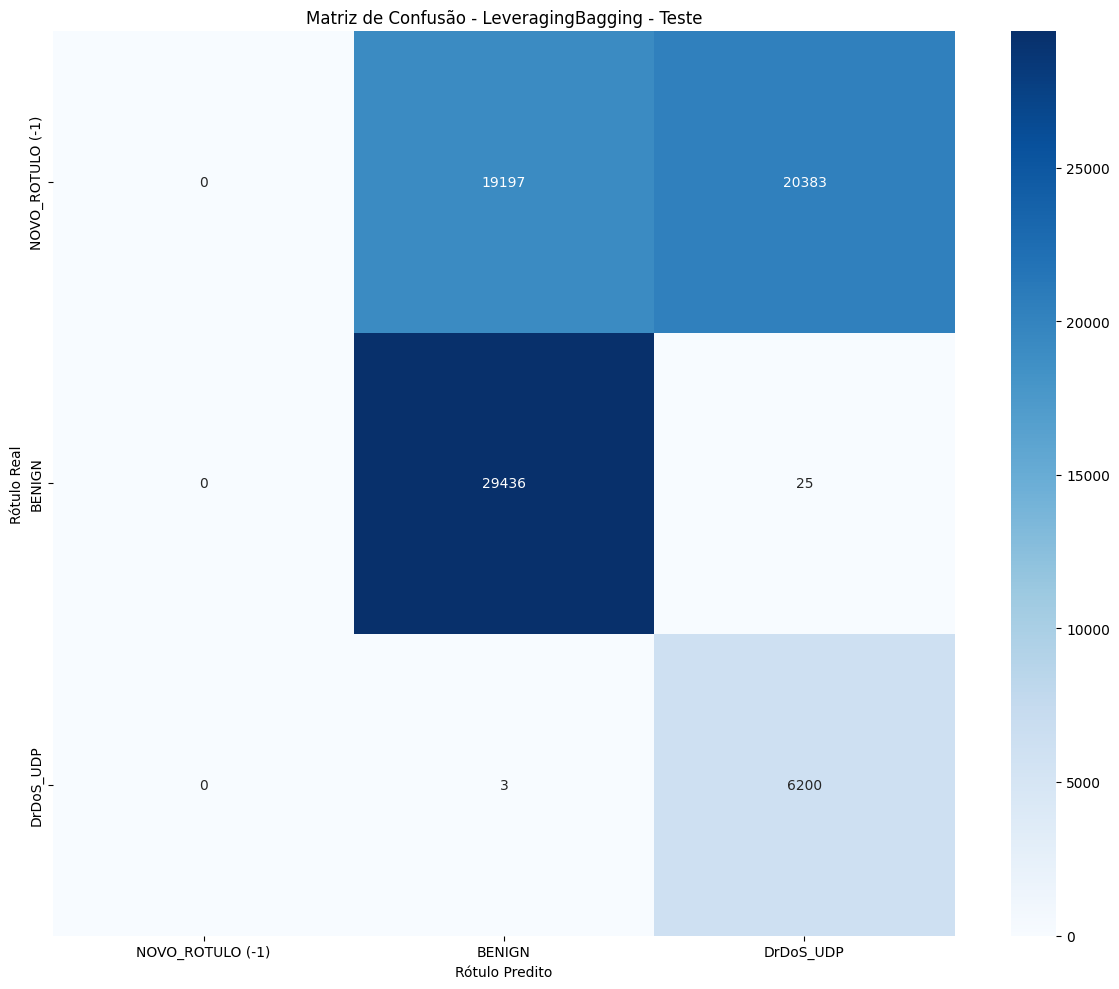

In [70]:
try:
    print(f"Carregando encoder de: {ENCODER_PATH}")
    le_treino = joblib.load(ENCODER_PATH) 

    print(f"Carregando stream de treino de: {PATH_CSV_TREINO}")
    stream_treino = carregar_stream_do_csv(
        csv_path=PATH_CSV_TREINO,
        target_col_name=TARGET_COL,
        stream_name_prefix="TREINO_PASSADO"
    )
    
    print(f"Carregando stream de teste de: {PATH_CSV_TESTE}")
    stream_teste = carregar_stream_do_csv(
        csv_path=PATH_CSV_TESTE,
        target_col_name=TARGET_COL,
        stream_name_prefix="TESTE_FUTURO"
    )

    if stream_treino is not None and stream_teste is not None and le_treino is not None:
        # TREINAMENTO (Apenas no "Passado")        
        print("\nInicializando LeveragingBagging...")
        classifier = LeveragingBagging(schema=stream_treino.schema)

        print("Iniciando Treinamento (avaliação prequencial nos dados do 'Passado')...")
        start_train_time = time.time()
        
        results_train = prequential_evaluation(
            stream=stream_treino,
            learner=classifier,
            batch_size=1
        )
            
        end_train_time = time.time()
        training_duration = end_train_time - start_train_time

        print("\nResultados de Avaliação (Treino 'Passado' com LeveragingBagging):")
        print(f"Acurácia Cumulativa: {results_train['cumulative'].accuracy():.4f}")
        print(f"F1-Score Cumulativo: {results_train['cumulative'].f1_score():.4f}")
        print(f"Tempo de Treinamento: {training_duration:.2f} segundos")
        
        # TESTE futuro
        print("\nIniciando Teste (Holdout nos dados do 'Futuro')...")
        test_evaluator = ClassificationEvaluator(schema=stream_teste.schema) 
        y_true_list = []
        y_pred_list = []
        
        start_test_time = time.time()
        
        stream_teste.restart()
        while stream_teste.has_more_instances():
            instance = stream_teste.next_instance()
            predicted_index = classifier.predict(instance)
            test_evaluator.update(instance.y_index, predicted_index)
            y_true_list.append(instance.y_index)
            y_pred_list.append(predicted_index)
            
        end_test_time = time.time()
        test_duration = end_test_time - start_test_time

        print("\nResultados de Avaliação (Teste 'Futuro' com LeveragingBagging) - (via CapyMOA):")
        print(f"Acurácia Cumulativa: {test_evaluator.accuracy():.4f}")
        print(f"F1-Score Cumulativo: {test_evaluator.f1_score():.4f}")
        print(f"Tempo de Teste: {test_duration:.2f} segundos")

        gerar_relatorio_e_heatmap(
            y_true_list, 
            y_pred_list, 
            le_treino, 
            model_name="LeveragingBagging"
        )

    else:
        print("ERRO: Falha ao carregar um ou mais artefatos (encoder ou streams).")

except NameError as e:
    print(f"ERRO: Funções/Variáveis não definidas. {e}")
except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado. Verifique os caminhos em PATH_*. {e}")
except Exception as e:
    print(f"ERRO INESPERADO NA CÉLULA: {e}")

## HoeffdingAdaptiveTree

https://capymoa.org/api/modules/capymoa.classifier.HoeffdingAdaptiveTree.html

Carregando encoder de: datasets/label_encoder_treino.joblib
Carregando stream de treino de: datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv

--- Carregando Stream do CSV: datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv ---
  [Passo 1/2] CSV carregado. Shape: (300972, 79)
  [Passo 2/2] Dados preparados: X_shape=(300972, 78), y_shape=(300972,).
Stream (Capymoa) recarregado e pronto para uso.
Carregando stream de teste de: datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv

--- Carregando Stream do CSV: datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv ---
  [Passo 1/2] CSV carregado. Shape: (75244, 79)
  [Passo 2/2] Dados preparados: X_shape=(75244, 78), y_shape=(75244,).
Stream (Capymoa) recarregado e pronto para uso.

Inicializando HoeffdingAdaptiveTree...
Iniciando Treinamento (avaliação prequencial nos dados do 'Passado')...

Resultados de Avaliação (Treino 'Passado' com HAT):
Acurácia Cumulativa: 99.6438
F1-Score Cumulativo: 99.5168
Tempo de Treinamento:

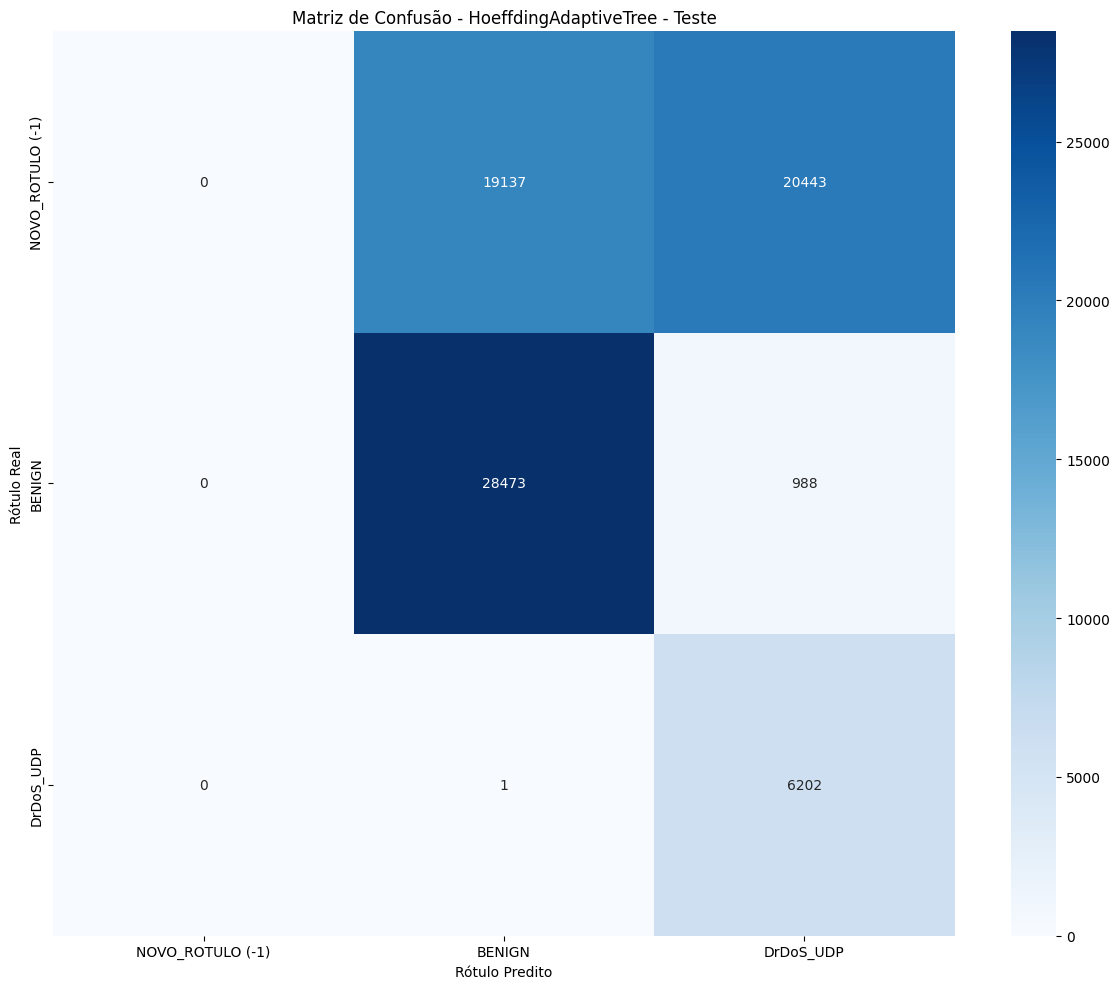

In [ ]:
try:
    print(f"Carregando encoder de: {ENCODER_PATH}")
    le_treino = joblib.load(ENCODER_PATH) 

    print(f"Carregando stream de treino de: {PATH_CSV_TREINO}")
    stream_treino = carregar_stream_do_csv(
        csv_path=PATH_CSV_TREINO,
        target_col_name=TARGET_COL,
        stream_name_prefix="TREINO_PASSADO"
    )
    
    print(f"Carregando stream de teste de: {PATH_CSV_TESTE}")
    stream_teste = carregar_stream_do_csv(
        csv_path=PATH_CSV_TESTE,
        target_col_name=TARGET_COL,
        stream_name_prefix="TESTE_FUTURO"
    )

    if stream_treino is not None and stream_teste is not None and le_treino is not None:
        # TREINAMENTO (Apenas no "Passado")        
        print("\nInicializando HoeffdingAdaptiveTree...")
        classifier = HoeffdingAdaptiveTree(schema=stream_treino.schema)

        print("Iniciando Treinamento (avaliação prequencial nos dados do 'Passado')...")
        start_train_time = time.time()
        
        results_train = prequential_evaluation(
            stream=stream_treino,
            learner=classifier,
            batch_size=1
        )
            
        end_train_time = time.time()
        training_duration = end_train_time - start_train_time

        print("\nResultados de Avaliação (Treino 'Passado' com HAT):")
        print(f"Acurácia Cumulativa: {results_train['cumulative'].accuracy():.4f}")
        print(f"F1-Score Cumulativo: {results_train['cumulative'].f1_score():.4f}")
        print(f"Tempo de Treinamento: {training_duration:.2f} segundos")
        
        #  TESTE (Futuro)
        print("\nIniciando Teste (Holdout nos dados do 'Futuro')...")
        test_evaluator = ClassificationEvaluator(schema=stream_teste.schema) 
        y_true_list = []
        y_pred_list = []
        
        start_test_time = time.time()
        
        stream_teste.restart()
        while stream_teste.has_more_instances():
            instance = stream_teste.next_instance()
            predicted_index = classifier.predict(instance)
            test_evaluator.update(instance.y_index, predicted_index)
            y_true_list.append(instance.y_index)
            y_pred_list.append(predicted_index)
            
        end_test_time = time.time()
        test_duration = end_test_time - start_test_time

        print("\nResultados de Avaliação (Teste 'Futuro' com HAT) - (via CapyMOA):")
        print(f"Acurácia Cumulativa: {test_evaluator.accuracy():.4f}")
        print(f"F1-Score Cumulativo: {test_evaluator.f1_score():.4f}")
        print(f"Tempo de Teste: {test_duration:.2f} segundos")

        gerar_relatorio_e_heatmap(
            y_true_list, 
            y_pred_list, 
            le_treino, 
            model_name="HoeffdingAdaptiveTree"
        )

    else:
        print("ERRO: Falha ao carregar um ou mais artefatos (encoder ou streams).")

except NameError as e:
    print(f"ERRO: Funções/Variáveis não definidas. {e}")
except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado. Verifique os caminhos em PATH_*. {e}")
except Exception as e:
    print(f"ERRO INESPERADO NA CÉLULA: {e}")

## AdaptativeRandomForestClassifier

https://capymoa.org/api/modules/capymoa.classifier.AdaptiveRandomForestClassifier.html

Carregando encoder de: datasets/label_encoder_treino.joblib
Carregando stream de treino de: datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv

--- Carregando Stream do CSV: datasets\CICDDoS2019\data\cicddos_stream_TREINO_0112.csv ---
  [Passo 1/2] CSV carregado. Shape: (300972, 79)
  [Passo 2/2] Dados preparados: X_shape=(300972, 78), y_shape=(300972,).
Stream (Capymoa) recarregado e pronto para uso.
Carregando stream de teste de: datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv

--- Carregando Stream do CSV: datasets\CICDDoS2019\data\cicddos_stream_TESTE_0112.csv ---
  [Passo 1/2] CSV carregado. Shape: (75244, 79)
  [Passo 2/2] Dados preparados: X_shape=(75244, 78), y_shape=(75244,).
Stream (Capymoa) recarregado e pronto para uso.

Inicializando AdaptiveRandomForestClassifier...
Iniciando Treinamento (avaliação prequencial nos dados do 'Passado')...

Resultados de Avaliação (Treino 'Passado' com ARF):
Acurácia Cumulativa: 99.8658
F1-Score Cumulativo: 99.8288
Tempo de Tre

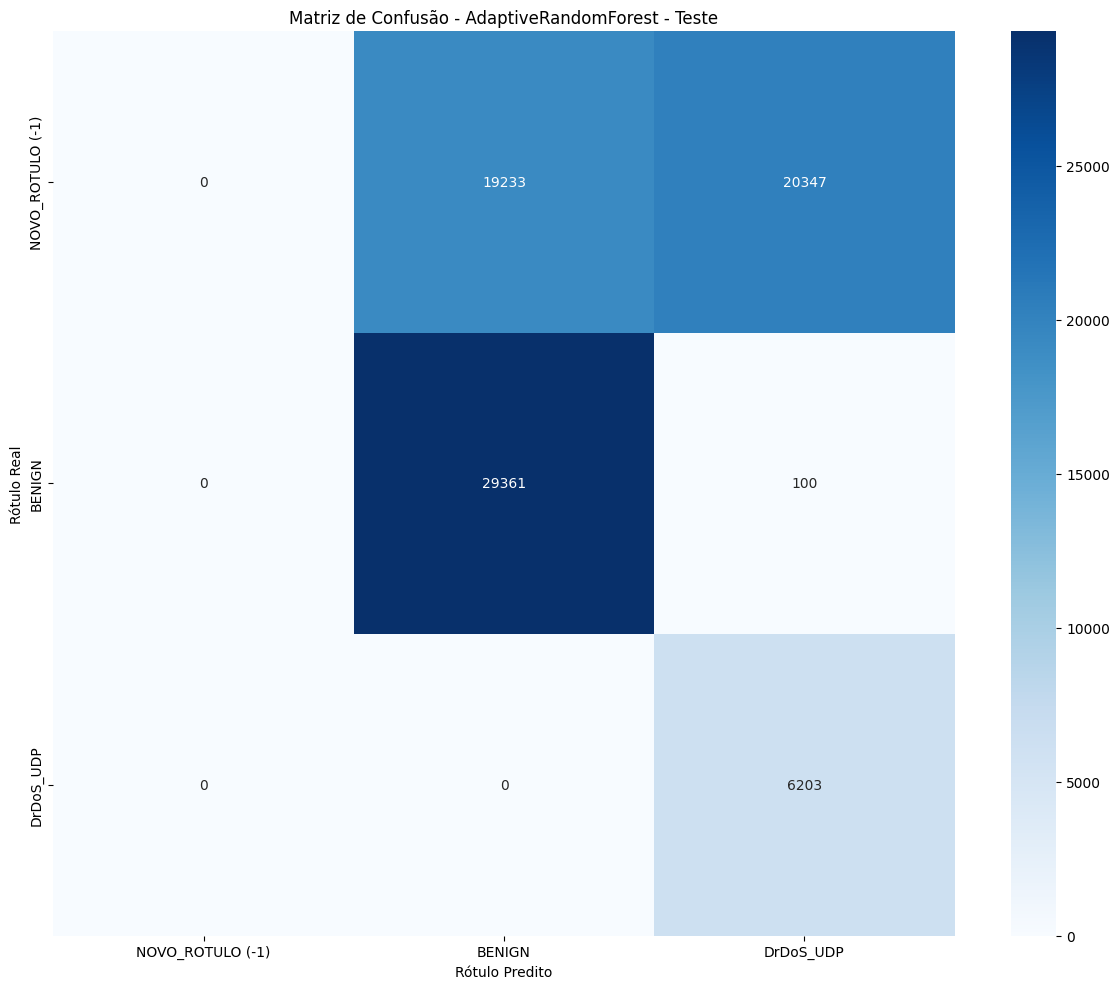

In [72]:
try:
    print(f"Carregando encoder de: {ENCODER_PATH}")
    le_treino = joblib.load(ENCODER_PATH) # Encoder do "Passado"

    print(f"Carregando stream de treino de: {PATH_CSV_TREINO}")
    stream_treino = carregar_stream_do_csv(
        csv_path=PATH_CSV_TREINO,
        target_col_name=TARGET_COL,
        stream_name_prefix="TREINO_PASSADO"
    )
    
    print(f"Carregando stream de teste de: {PATH_CSV_TESTE}")
    stream_teste = carregar_stream_do_csv(
        csv_path=PATH_CSV_TESTE,
        target_col_name=TARGET_COL,
        stream_name_prefix="TESTE_FUTURO"
    )

    if stream_treino is not None and stream_teste is not None and le_treino is not None:
        # TREINAMENTO 
        print("\nInicializando AdaptiveRandomForestClassifier...")
        classifier = AdaptiveRandomForestClassifier(schema=stream_treino.schema)

        print("Iniciando Treinamento (avaliação prequencial nos dados do 'Passado')...")
        start_train_time = time.time()
        
        results_train = prequential_evaluation(
            stream=stream_treino,
            learner=classifier,
            batch_size=1
        )
            
        end_train_time = time.time()
        training_duration = end_train_time - start_train_time

        print("\nResultados de Avaliação (Treino 'Passado' com ARF):")
        print(f"Acurácia Cumulativa: {results_train['cumulative'].accuracy():.4f}")
        print(f"F1-Score Cumulativo: {results_train['cumulative'].f1_score():.4f}")
        print(f"Tempo de Treinamento: {training_duration:.2f} segundos")
        
        # TESTE
        print("\nIniciando Teste (Holdout nos dados do 'Futuro')...")
        test_evaluator = ClassificationEvaluator(schema=stream_teste.schema) 
        y_true_list = []
        y_pred_list = []
        
        start_test_time = time.time()
        
        stream_teste.restart()
        while stream_teste.has_more_instances():
            instance = stream_teste.next_instance()
            predicted_index = classifier.predict(instance)
            test_evaluator.update(instance.y_index, predicted_index)
            y_true_list.append(instance.y_index)
            y_pred_list.append(predicted_index)
            
        end_test_time = time.time()
        test_duration = end_test_time - start_test_time

        print("\nResultados de Avaliação (Teste 'Futuro' com ARF) - (via CapyMOA):")
        print(f"Acurácia Cumulativa: {test_evaluator.accuracy():.4f}")
        print(f"F1-Score Cumulativo: {test_evaluator.f1_score():.4f}")
        print(f"Tempo de Teste: {test_duration:.2f} segundos")

        gerar_relatorio_e_heatmap(
            y_true_list, 
            y_pred_list, 
            le_treino, 
            model_name="AdaptiveRandomForest"
        )

    else:
        print("ERRO: Falha ao carregar um ou mais artefatos (encoder ou streams).")

except NameError as e:
    print(f"ERRO: Funções/Variáveis não definidas. {e}")
except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado. Verifique os caminhos em PATH_*. {e}")
except Exception as e:
    print(f"ERRO INESPERADO NA CÉLULA: {e}")